# Embed grid of 10,000 FSPS spectra with parameters randomly sampled

In [1]:
# imports and plotting setup
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from astroML.plotting import setup_text_plots
import h5py

np.set_printoptions(suppress=True)
setup_text_plots(fontsize=16)
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)
mpl.rc('font', size=16, family='serif', style='normal', variant='normal', stretch='normal', weight='bold')
mpl.rc('legend', labelspacing=0.1, handlelength=2, fontsize=10)
mpl.rc('axes', labelweight='black')

In [2]:
# code from megaman_spectra.py 

from megaman.geometry import Geometry
from megaman.embedding import SpectralEmbedding
from scipy.io import mmwrite
from scipy.sparse.csgraph import connected_components

f = h5py.File('../data/1e4_randsamp_age_model_spectra.hdf5','r')
spectra = f['spectra'][:]
wave = f['wave'][:]
taus = f['taus'][:]
ages = f['ages'][:]
zs = f['zs'][:]
dusts = f['dusts'][:]
sigmas = f['sigmas'][:]
f.close()

In [78]:
radius = 0.9 # reduced from original 35000 to run on narrower spectral range/normalized data
adjacency_method = 'cyflann'
cyflann_kwds = {'index_type':'kdtrees', 'num_trees':100}
adjacency_kwds = {'radius':radius, 'cyflann_kwds':cyflann_kwds}
affinity_method = 'gaussian'
affinity_kwds = {'radius':radius}

geom = Geometry(adjacency_method=adjacency_method, adjacency_kwds=adjacency_kwds, 
                affinity_method=affinity_method, affinity_kwds=affinity_kwds)

geom.set_data_matrix(spectra)
adjacency_matrix = geom.compute_adjacency_matrix()
affinity_matrix = geom.compute_affinity_matrix()

new_radius = np.max(adjacency_matrix.data)

n, labels = connected_components(affinity_matrix, directed=False, return_labels=True)
print "Number of connected components: ", n
#wh = np.where(labels > 0)
#geom.X = np.delete(geom.X, wh, 0) 

#geom.affinity_matrix = np.delete(geom.affinity_matrix, wh, 0)
#geom.affinity_matrix = np.delete(geom.affinity_matrix, wh, 1)

affinity_kwds = {'radius':new_radius}
laplacian_method = 'geometric'
laplacian_kwds = {'scaling_epps':new_radius}
geom.affinity_kwds = affinity_kwds
geom.laplacian_method = laplacian_method
geom.laplacian_kwds = laplacian_kwds

spectral = SpectralEmbedding(n_components=3, eigen_solver='amg', drop_first=True, geom=geom)
embed = spectral.fit_transform(geom.X)

mmwrite('embed3d_1e4_randsamp_age_model_spectra.mtx', embed)

Number of connected components:  30


## Plots here show result for r=0.9

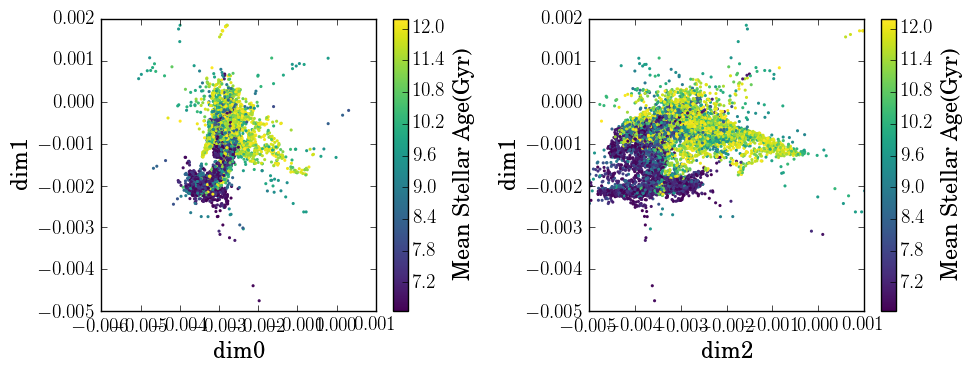

In [89]:
plot_embed(ages, 'Mean Stellar Age(Gyr)', axlim=True)

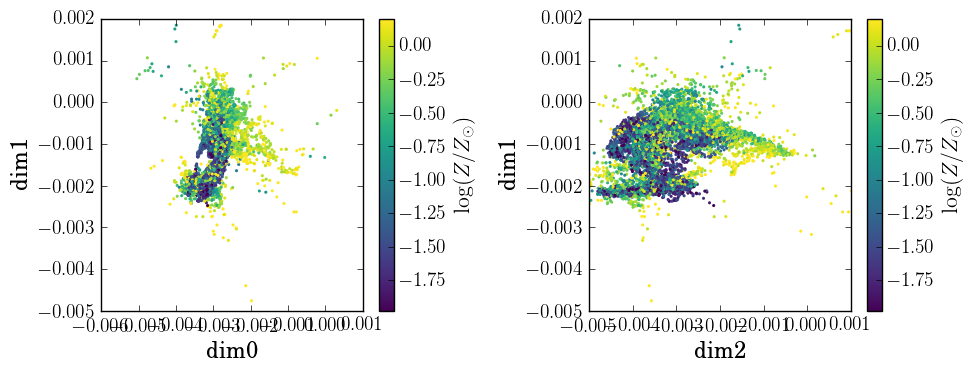

In [90]:
plot_embed(zs, r'$\log(Z/Z_\odot)$', axlim=True)

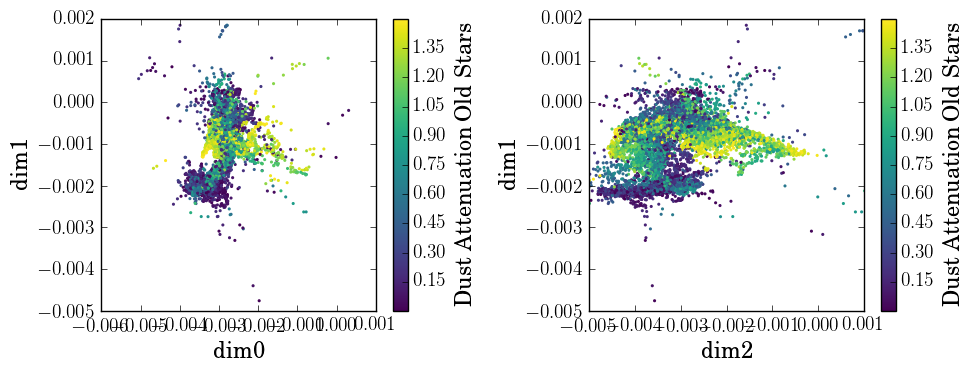

In [91]:
plot_embed(dusts, 'Dust Attenuation Old Stars', axlim=True)

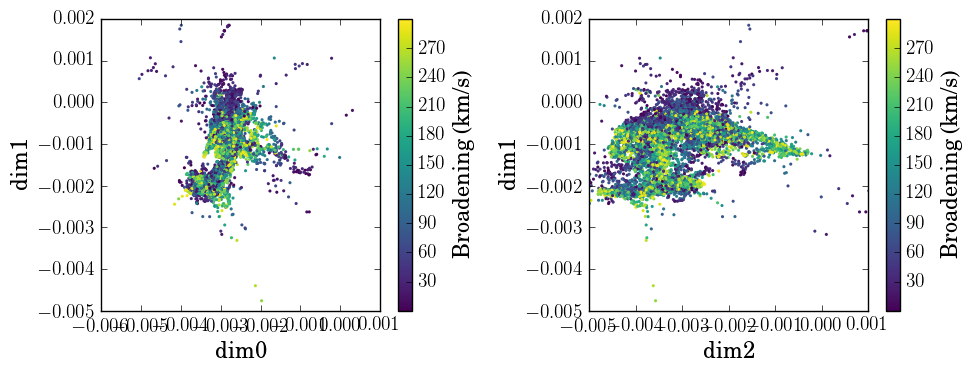

In [92]:
plot_embed(sigmas, 'Broadening (km/s)', axlim=True)

## Plots here show result for r=1.05

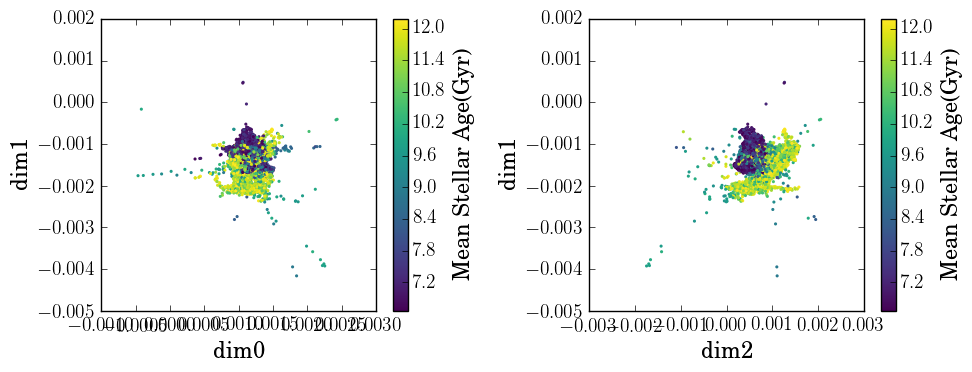

In [72]:
plot_embed(ages, 'Mean Stellar Age(Gyr)', axlim=True)

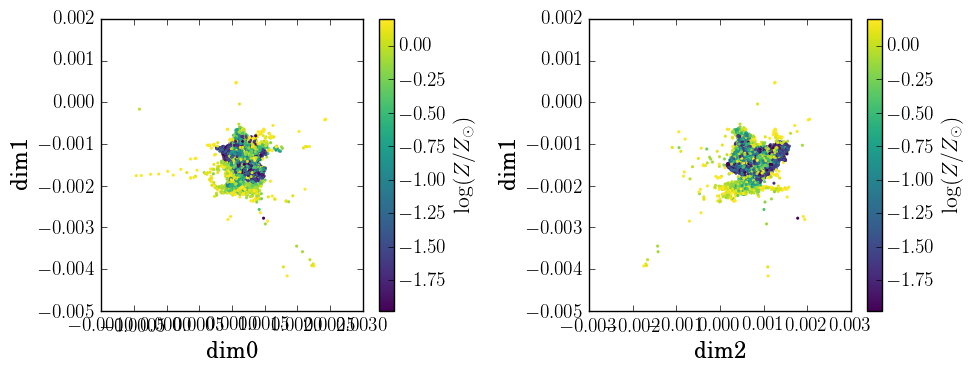

In [73]:
plot_embed(zs, r'$\log(Z/Z_\odot)$', axlim=True)

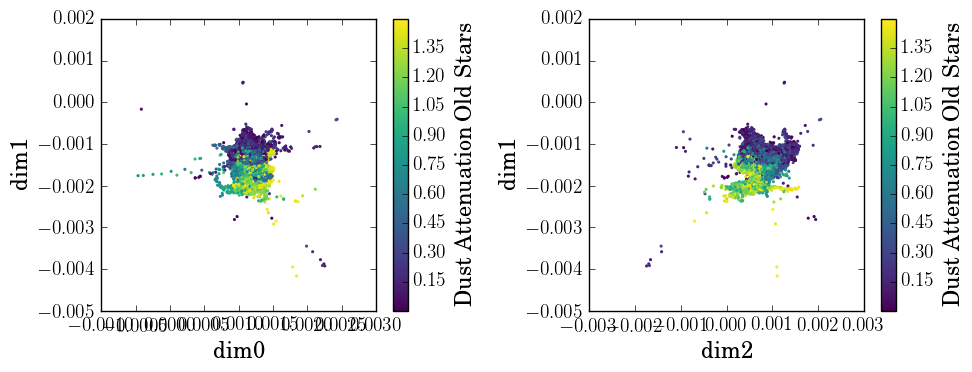

In [74]:
plot_embed(dusts, 'Dust Attenuation Old Stars', axlim=True)

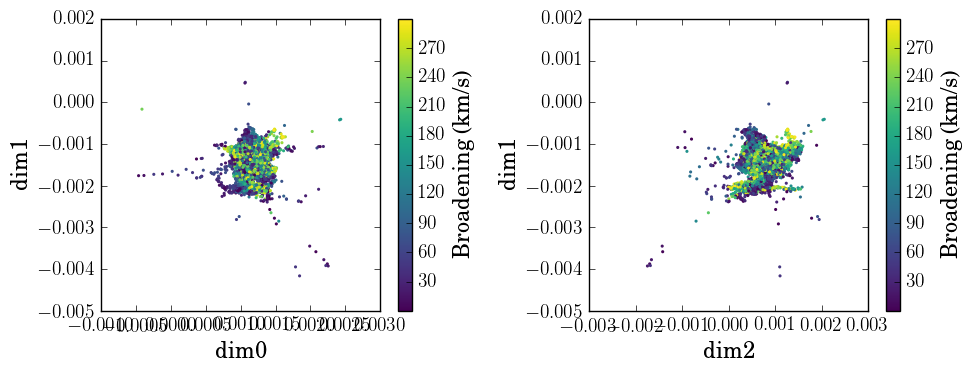

In [75]:
plot_embed(sigmas, 'Broadening (km/s)', axlim=True)

### Investigating the disconnected components

In [81]:
hmm = np.where(labels > 0)[0][:]
np.shape(hmm)

(39,)

In [82]:
for ii in hmm:
    print zip(ages, zs, dusts, sigmas)[ii]

(9.4941637635612874, 0.10000000000000001, 0.11956697589077925, 1.5690605094072052)
(9.0466444853403498, 0.10000000000000001, 0.14524810948657718, 17.808114499175332)
(10.022750749782464, 0.0, 0.054940228688281023, 235.92569817202815)
(9.1964352200871886, 0.20000000000000001, 0.016385845501351193, 245.31881659433367)
(9.9539981218525142, 0.20000000000000001, 0.91916673466469323, 73.637629053770297)
(9.9460316169867866, 0.10000000000000001, 0.99804670749451563, 50.680550168311321)
(9.7273872254299665, -0.29999999999999999, 1.4393728730978606, 41.862282845781763)
(9.9299976986287657, 0.10000000000000001, 0.95633019131110197, 68.206353032393906)
(9.8127245967969561, -0.10000000000000001, 0.18991532803245303, 3.8151662990910773)
(10.133353976725804, 0.20000000000000001, 1.1360282761796516, 79.791813109338037)
(10.406149224555032, 0.20000000000000001, 0.27842753836969891, 160.03587104056737)
(9.6435916239092805, 0.20000000000000001, 0.072118488677498371, 104.74010869733496)
(10.0119165370903

## Testing the Mahalonobis Distance

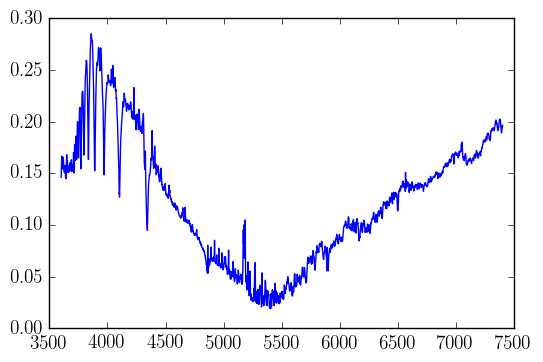

In [3]:
stds = np.std(spectra, axis=0)
plt.figure()
plt.plot(wave, stds)

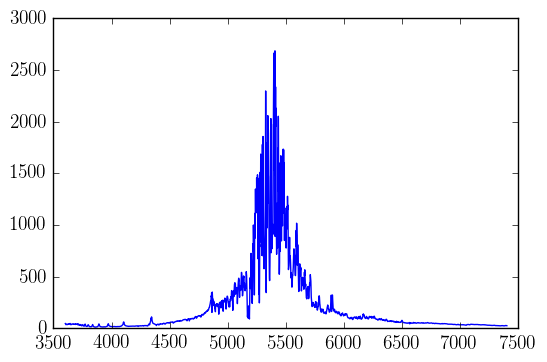

In [4]:
ivars = 1./(np.std(spectra, axis=0)**2)
plt.figure()
plt.plot(wave, ivars)

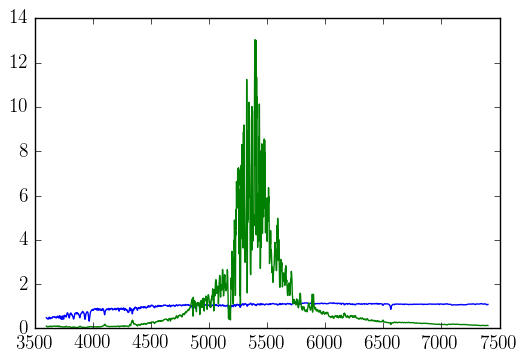

In [5]:
spectra_scaled = spectra * ivars
norms = spectra_scaled.shape[1] / np.sum(spectra_scaled, axis=1)
spectra_scaled_norm = spectra_scaled * norms[:,np.newaxis]

plt.figure()
plt.plot(wave, np.mean(spectra, axis=0))
plt.plot(wave, np.mean(spectra_scaled_norm, axis=0))

In [6]:
radius = 0.9
adjacency_method = 'cyflann'
cyflann_kwds = {'index_type':'kdtrees', 'num_trees':100}
adjacency_kwds = {'radius':radius, 'cyflann_kwds':cyflann_kwds}
affinity_method = 'gaussian'
affinity_kwds = {'radius':radius}

geom = Geometry(adjacency_method=adjacency_method, adjacency_kwds=adjacency_kwds, 
                affinity_method=affinity_method, affinity_kwds=affinity_kwds)

geom.set_data_matrix(spectra_scaled_norm)
adjacency_matrix = geom.compute_adjacency_matrix()
affinity_matrix = geom.compute_affinity_matrix()

new_radius = np.max(adjacency_matrix.data)

n, labels = connected_components(affinity_matrix, directed=False, return_labels=True)
print "Number of connected components: ", n
#wh = np.where(labels > 0)
#geom.X = np.delete(geom.X, wh, 0) 

#geom.affinity_matrix = np.delete(geom.affinity_matrix, wh, 0)
#geom.affinity_matrix = np.delete(geom.affinity_matrix, wh, 1)

affinity_kwds = {'radius':new_radius}
laplacian_method = 'geometric'
laplacian_kwds = {'scaling_epps':new_radius}
geom.affinity_kwds = affinity_kwds
geom.laplacian_method = laplacian_method
geom.laplacian_kwds = laplacian_kwds

#solver_kwds = {'maxiter':maxiter, 'tol':5e-7}

spectral = SpectralEmbedding(n_components=3, eigen_solver='amg', drop_first=True, geom=geom)
embed = spectral.fit_transform(geom.X)

mmwrite('embed3d_1e4_randsamp_age_model_spectra_scaled.mtx', embed)

Number of connected components:  3


/Users/Grace/anaconda/envs/megaman/lib/python2.7/site-packages/megaman/embedding/spectral_embedding.py:201: UserWarning: Graph is not fully connected: spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected: "


In [34]:
def plot_embed(color, label, axlim=True):
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    
    a = ax[0].scatter(embed[:,0], embed[:,1], c=color, lw=0, s=5, cmap='viridis')
    plt.colorbar(a, ax=ax[0], label=label)
    ax[0].set_xlabel('dim0')
    ax[0].set_ylabel('dim1')

    b = ax[1].scatter(embed[:,2], embed[:,1], c=color, lw=0, s=5, cmap='viridis')
    plt.colorbar(b, ax=ax[1], label=label)
    ax[1].set_xlabel('dim2')
    ax[1].set_ylabel('dim1')
    
    if axlim:
        ax[0].set_xlim([0.0022, 0.0028])
        ax[0].set_ylim([-0.004, -0.001])
        ax[1].set_xlim([-0.02, 0.03])
        ax[1].set_ylim([-0.004, -0.001])
        
    plt.tight_layout()

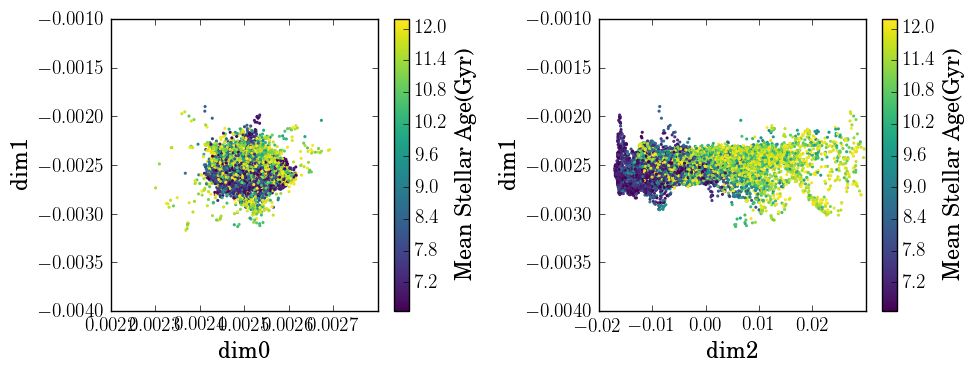

In [35]:
plot_embed(ages, 'Mean Stellar Age(Gyr)', axlim=True)

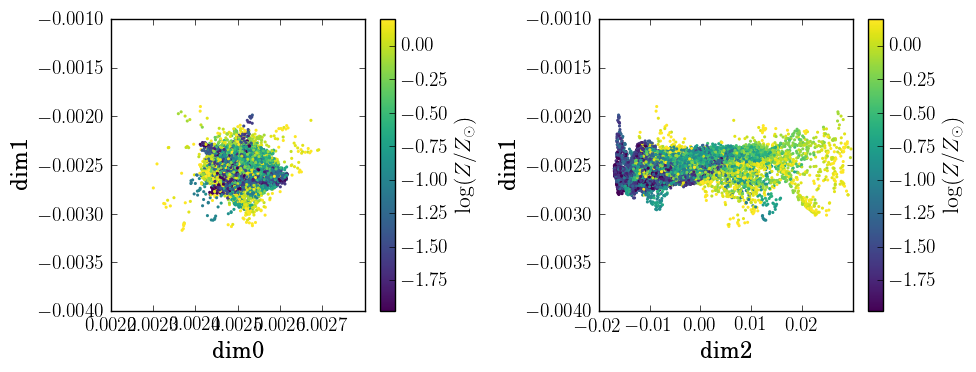

In [36]:
plot_embed(zs, r'$\log(Z/Z_\odot)$', axlim=True)

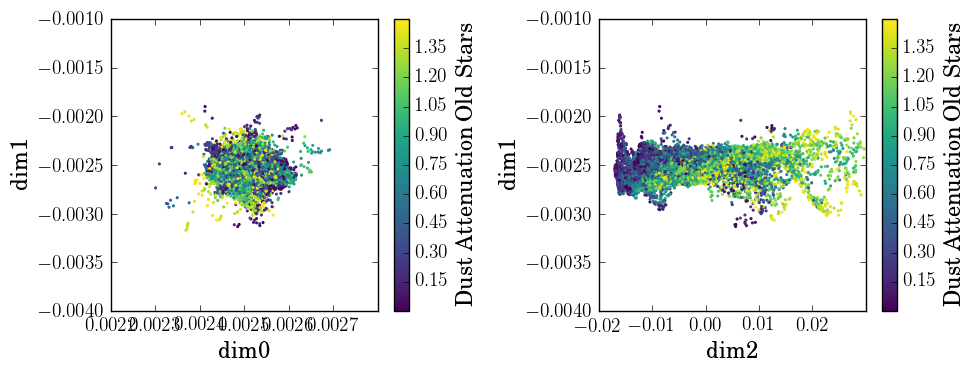

In [37]:
plot_embed(dusts, 'Dust Attenuation Old Stars', axlim=True)

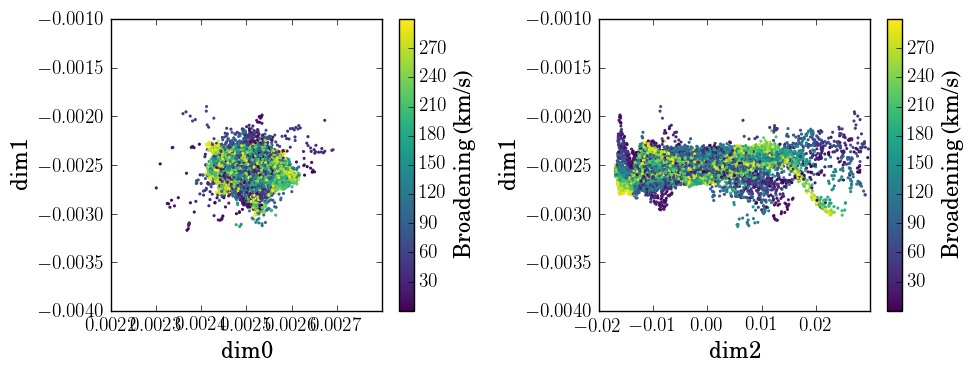

In [38]:
plot_embed(sigmas, 'Broadening (km/s)', axlim=True)

In [39]:
hmm = np.where(labels > 0)[0][:]
np.shape(hmm)

(2,)

In [40]:
for ii in hmm:
    print zip(ages, zs, dusts, sigmas)[ii]

(11.428478233777222, 0.20000000000000001, 1.4011728213722492, 62.886512862441322)
(12.078913151359814, 0.20000000000000001, 0.64499222648314647, 61.512735784150571)


## Now, let's check how performace changes when using a different solver

In [41]:
radius = 0.9 # reduced from original 35000 to run on narrower spectral range/normalized data
adjacency_method = 'cyflann'
cyflann_kwds = {'index_type':'kdtrees', 'num_trees':100}
adjacency_kwds = {'radius':radius, 'cyflann_kwds':cyflann_kwds}
affinity_method = 'gaussian'
affinity_kwds = {'radius':radius}

geom = Geometry(adjacency_method=adjacency_method, adjacency_kwds=adjacency_kwds, 
                affinity_method=affinity_method, affinity_kwds=affinity_kwds)

geom.set_data_matrix(spectra_scaled_norm)
adjacency_matrix = geom.compute_adjacency_matrix()
affinity_matrix = geom.compute_affinity_matrix()

new_radius = np.max(adjacency_matrix.data)

n, labels = connected_components(affinity_matrix, directed=False, return_labels=True)
print "Number of connected components: ", n
#wh = np.where(labels > 0)
#geom.X = np.delete(geom.X, wh, 0) 

#geom.affinity_matrix = np.delete(geom.affinity_matrix, wh, 0)
#geom.affinity_matrix = np.delete(geom.affinity_matrix, wh, 1)

affinity_kwds = {'radius':new_radius}
laplacian_method = 'geometric'
laplacian_kwds = {'scaling_epps':new_radius}
geom.affinity_kwds = affinity_kwds
geom.laplacian_method = laplacian_method
geom.laplacian_kwds = laplacian_kwds

spectral = SpectralEmbedding(n_components=3, eigen_solver='arpack', drop_first=True, geom=geom)
embed = spectral.fit_transform(geom.X)

#mmwrite('embed3d_1e4_randsamp_age_model_spectra_scaled.mtx', embed)

Number of connected components:  3


In [89]:
def plot_embed(color, label, axlim=True):
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    
    a = ax[0].scatter(embed[:,0], embed[:,1], c=color, lw=0, s=5, cmap='viridis')
    plt.colorbar(a, ax=ax[0], label=label)
    ax[0].set_xlabel('dim0')
    ax[0].set_ylabel('dim1')

    b = ax[1].scatter(embed[:,2], embed[:,1], c=color, lw=0, s=5, cmap='viridis')
    plt.colorbar(b, ax=ax[1], label=label)
    ax[1].set_xlabel('dim2')
    ax[1].set_ylabel('dim1')
    
    if axlim:
        ax[0].set_xlim([-0.00409513,-0.00409515])
        ax[0].set_ylim([0.00815038, 0.00815040])
        ax[1].set_xlim([-0.02, 0.04])
        ax[1].set_ylim([0.00815038, 0.00815040])
    
    plt.tight_layout()

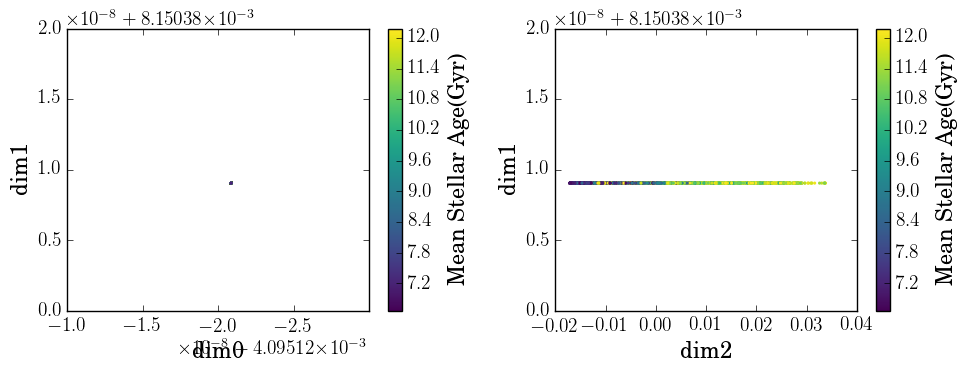

In [90]:
plot_embed(ages, 'Mean Stellar Age(Gyr)', axlim=True)

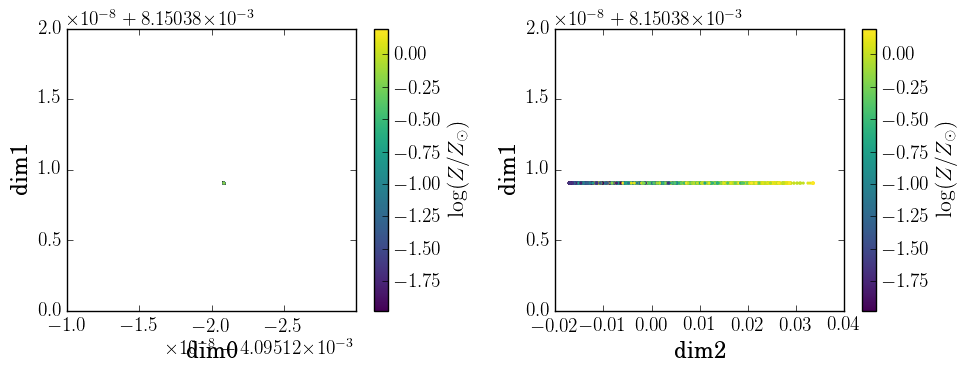

In [91]:
plot_embed(zs, r'$\log(Z/Z_\odot)$', axlim=True)

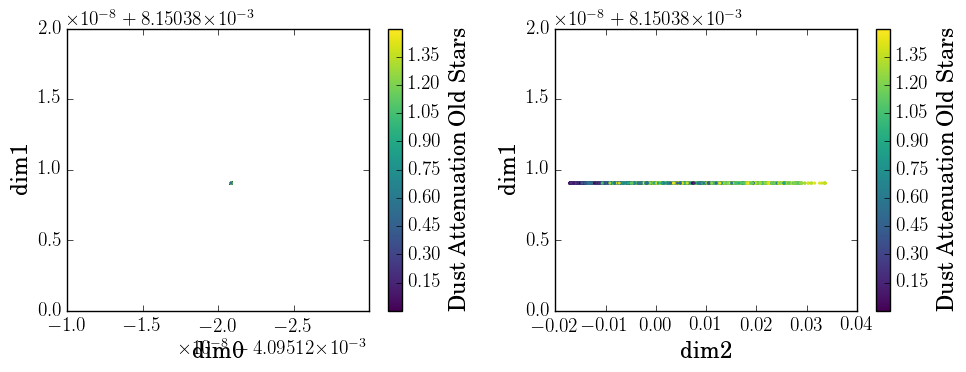

In [92]:
plot_embed(dusts, 'Dust Attenuation Old Stars', axlim=True)

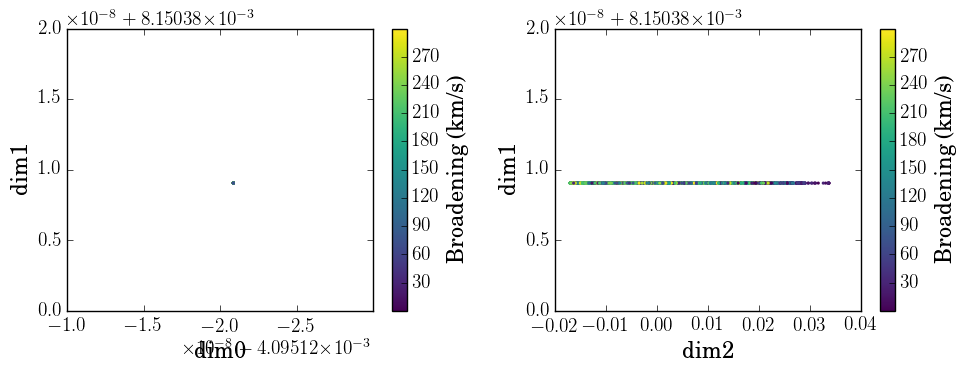

In [93]:
plot_embed(sigmas, 'Broadening (km/s)', axlim=True)

In [42]:
hmm = np.where(labels > 0)[0][:]
np.shape(hmm)

(2,)

In [43]:
for ii in hmm:
    print zip(ages, zs, dusts, sigmas)[ii]

(11.428478233777222, 0.20000000000000001, 1.4011728213722492, 62.886512862441322)
(12.078913151359814, 0.20000000000000001, 0.64499222648314647, 61.512735784150571)


In [88]:
np.unique(embed[:,0])

array([-0.8312599 , -0.00409514, -0.00409514, -0.00409514, -0.00409514,
       -0.00409514, -0.00409514, -0.00409514, -0.00409514, -0.00409514,
       -0.00409514, -0.00409514, -0.00409514, -0.00409514, -0.00409514,
       -0.00409514, -0.00409514, -0.00409514, -0.00409514, -0.00409514,
       -0.00409514, -0.00409514, -0.00409514, -0.00409514, -0.00409514,
       -0.00409514, -0.00409514, -0.00409514, -0.00409514, -0.00409514,
       -0.00409514, -0.00409514, -0.00409514, -0.00409514, -0.00409514,
       -0.00409514, -0.00409514, -0.00409514, -0.00409514, -0.00409514,
       -0.00409514, -0.00409514, -0.00409514, -0.00409514, -0.00409514,
       -0.00409514, -0.00409514, -0.00409514, -0.00409514, -0.00409514,
       -0.00409514, -0.00409514, -0.00409514, -0.00409514, -0.00409514,
       -0.00409514, -0.00409514, -0.00409514, -0.00409514, -0.00409514,
       -0.00409514, -0.00409514, -0.00409514, -0.00409514, -0.00409514,
       -0.00409514, -0.00409514, -0.00409514, -0.00409514, -0.00